In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("/xfs/home/tensor_zy/guoxuan/Task3/ChatGLM/inferencing")
sys.path.append("/xfs/home/tensor_zy/guoxuan/Task3/ChatGLM_tl")

In [2]:
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score, auc
from tqdm import tqdm
import pandas as pd
import json, torch

from cover_alpaca2jsonl import format_example

In [20]:
model_path = "THUDM/chatglm2-6b"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, load_in_8bit=False, device = "cuda")
model = AutoModel.from_pretrained(model_path, trust_remote_code=True, load_in_8bit=False, device_map = "auto")

from peft_tl import PeftModel
peft_path = "/xfs/home/tensor_zy/guoxuan/Task3/ChatGLM_tl/infoxlmr_finetune_cp_general"
model = PeftModel.from_pretrained(model, peft_path)

# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, device_map = "auto")
model = torch.compile(model)
model = model.eval()

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

### Load Dataset

In [13]:
from datasets import load_dataset
import datasets

dataset = load_dataset("boolq")
dataset = dataset['validation']

Found cached dataset boolq (/xfs/home/tensor_zy/.cache/huggingface/datasets/boolq/default/0.1.0/bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5)


  0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
dataset = dataset.to_pandas()
dataset['answer'] = dataset['answer'].astype('str')
dataset.head(2)

,question,answer,passage
0,does ethanol take more energy make that produces,False,All biomass goes through at least some of thes...
1,is house tax and property tax are same,True,Property tax or 'house tax' is a local tax on ...


In [15]:
dataset.columns = ['instruction', 'output', 'input']

In [16]:
dataset[["context","target"]] = dataset.apply(format_example, axis = 1, result_type="expand")
dataset.head(2)

,instruction,output,input,context,target
0,does ethanol take more energy make that produces,False,All biomass goes through at least some of thes...,Instruction: does ethanol take more energy mak...,False
1,is house tax and property tax are same,True,Property tax or 'house tax' is a local tax on ...,Instruction: is house tax and property tax are...,True


In [17]:
context = dataset['context'].tolist()
len(context)

3270

In [18]:
batch_size = 32

total_steps = dataset.shape[0]//batch_size
total_steps

102

In [21]:

res_list = []
res_sentences_list = []
out_text_list = []

for i in tqdm(range(total_steps+1)):
    tmp_context = context[i* batch_size:(i+1)* batch_size]
    tokens = tokenizer(tmp_context, return_tensors='pt', padding=True, max_length=512)
    for k in tokens.keys():
        tokens[k] = tokens[k].cuda()
    
    res = model.generate(**tokens, max_length=512)
    res_sentences = [tokenizer.decode(i) for i in res]
    out_text = [o.split("Answer: ")[1] for o in res_sentences]
    res_list += res
    res_sentences_list += res_sentences
    out_text_list += out_text
    torch.cuda.empty_cache()

100%|██████████| 103/103 [07:46<00:00,  4.53s/it]


: 

In [ ]:
res_list = [i.cpu() for i in res_list]

In [ ]:
dataset["res"] = res_list
dataset["res_sentences"] = res_sentences_list
dataset["out_text"] = out_text_list

In [ ]:
out_text_list[:10]

['1.34', ' yes', '1. Yes.', ' yes', '1', ' no', '1', '71', '1.', ' yes']

In [ ]:
def change_target(x):
    if "True" in x or 'true' in x:
        return "True"
    elif 'False' in x or 'false' in x:
        return "False"
    else:
        return 'missing'

<AxesSubplot:>

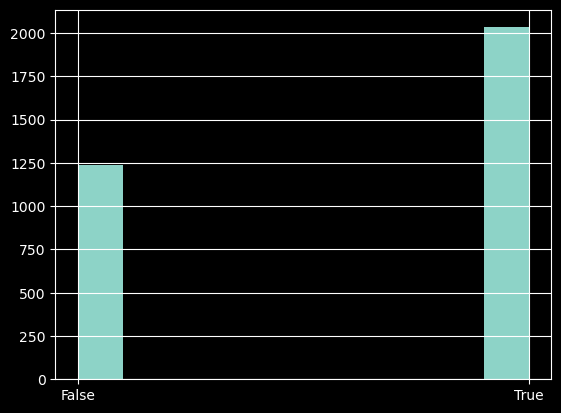

In [ ]:
# dataset["new_target"] = dataset["target"].apply(change_target)
dataset["new_target"] = dataset["target"]
dataset["new_target"].hist()

<AxesSubplot:>

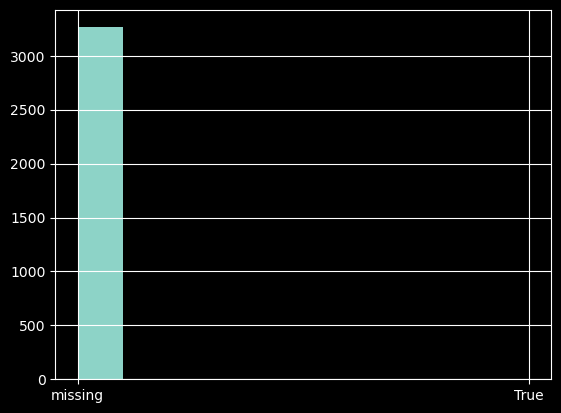

In [ ]:
dataset["new_out"] = dataset["out_text"].apply(change_target)
dataset["new_out"].hist()

### 8-bit

In [ ]:
acc = accuracy_score(dataset["new_target"], dataset["new_out"])
acc

0.0009174311926605505

In [ ]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "macro")
f1

0.0009808729769494849

In [ ]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "micro")
f1

0.0009174311926605505

In [ ]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "weighted")
f1

0.0018294630845305533

### Full

In [ ]:
acc = accuracy_score(dataset["new_target"], dataset["new_out"])
acc

0.0009174311926605505

In [ ]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "macro")
f1

0.0009808729769494849

In [ ]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "micro")
f1

0.0009174311926605505

In [ ]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "weighted")
f1

0.0018294630845305533

In [ ]:
dataset.to_csv("fiqa_ori.csv")